# Point cloud classification


In [ ]:
!pip install trimesh


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls


In [ ]:

import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import sys
from google.colab import drive
from plyfile import (PlyData, PlyElement, make2d, PlyParseError, PlyProperty)

tf.random.set_seed(1234)


In [ ]:
def load_ply_data(filename, point_num):
    plydata = PlyData.read(filename)
    pc = plydata['vertex'].data[:point_num]
    pc_array = np.array([[x, y, z] for x,y,z in pc])
    return pc_array

In [ ]:
def dataset_revised(NUM_POINTS):
  name='drive/My Drive/flight_PLY/'
  train_points=[]
  test_point=[]
  train_labels=[]
  test_labels=[]
  size=NUM_POINTS

  class_map={}

  DATA_DIR=os.path.dirname(name)
  folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))


  for i, folder in enumerate(folders):
    print("Class:", format(os.path.basename(folder)))
    class_map[i]=folder.split("/")[-1]

    train_files = glob.glob(os.path.join(folder, "train/*"))
    test_files = glob.glob(os.path.join(folder, "test/*"))
    

    for f in train_files:
      temp_point=load_ply_data(f,size)
      train_points.append(temp_point)
      
      train_labels.append(i)

    for f in test_files:
      temp_point=load_ply_data(f,size)
      test_point.append(temp_point)
      
      test_labels.append(i)


  # test='drive/My Drive/test/'
  # TEST_DIR=os.path.dirname(test)
  # test_directory= glob.glob(os.path.join(TEST_DIR, "[!README]*"))
  # for i, filename in enumerate (test_directory):   
  #     print(filename) 
  #     temp_point=load_ply_data(filename,size)
  #     test_point.append(temp_point)
  #     test_labels.append(i)

     
  print("Train labels:",np.array(train_labels).shape)
  print("Train points",np.array(train_points).shape)

  print("Test labels:",np.array(test_labels).shape)
  print("test points:",np.array(test_point).shape)
  print("Import Successful")
  print(class_map)

  return np.array(train_points), np.array(test_point), np.array(train_labels), np.array(test_labels), class_map
      




In [ ]:
NUM_POINTS = 1300
NUM_CLASSES = 3
BATCH_SIZE = 42

train_points, test_points, train_labels, test_labels, CLASS_MAP = dataset_revised(
    NUM_POINTS
)

Class: a319
Class: a321
Class: a320
Train labels: (123,)
Train points (123, 1300, 3)
Test labels: (37,)
test points: (37, 1300, 3)
Import Successful
{0: 'a319', 1: 'a321', 2: 'a320'}


In [ ]:

def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float32)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


In [ ]:

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)



In [ ]:

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))



In [ ]:

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])



In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1300, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1300, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1300, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1300, 32)     0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=200, validation_data=test_dataset)


Epoch 1/200
3/3 [==============================] - 1s 294ms/step - loss: 3.8085 - sparse_categorical_accuracy: 0.4715 - val_loss: 12.0671 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/200
3/3 [==============================] - 0s 114ms/step - loss: 2.9208 - sparse_categorical_accuracy: 0.8455 - val_loss: 6.1426 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/200
3/3 [==============================] - 0s 117ms/step - loss: 2.4677 - sparse_categorical_accuracy: 0.9268 - val_loss: 3.0551 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/200
3/3 [==============================] - 0s 116ms/step - loss: 2.0588 - sparse_categorical_accuracy: 0.9675 - val_loss: 2.2453 - val_sparse_categorical_accuracy: 0.8378
Epoch 5/200
3/3 [==============================] - 0s 117ms/step - loss: 1.8066 - sparse_categorical_accuracy: 0.9593 - val_loss: 2.0136 - val_sparse_categorical_accuracy: 0.7568
Epoch 6/200
3/3 [==============================] - 0s 114ms/step - loss: 1.6364 - sparse_categorical_acc

IndexError: ignored

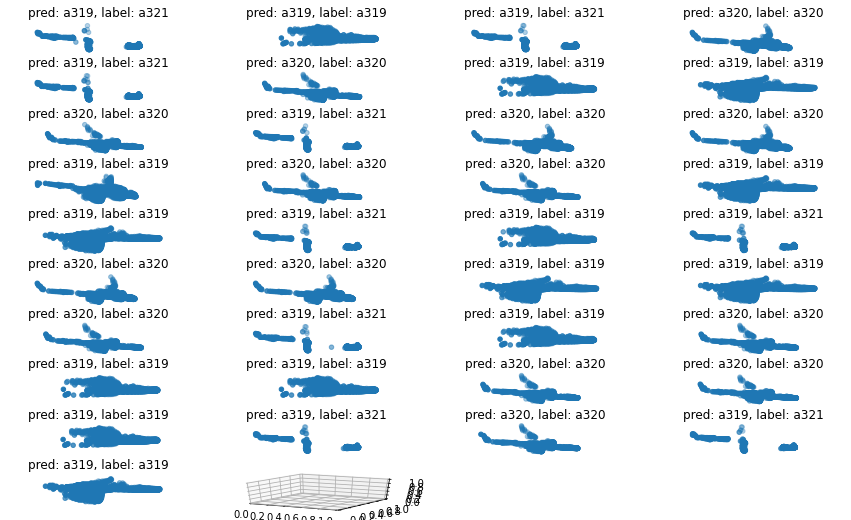

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:42, ...]
labels = labels[:42, ...]


# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

fig = plt.figure(figsize=(15, 10))
for i in range(42):
    ax = fig.add_subplot(11, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
    
plt.show()
